Version 1

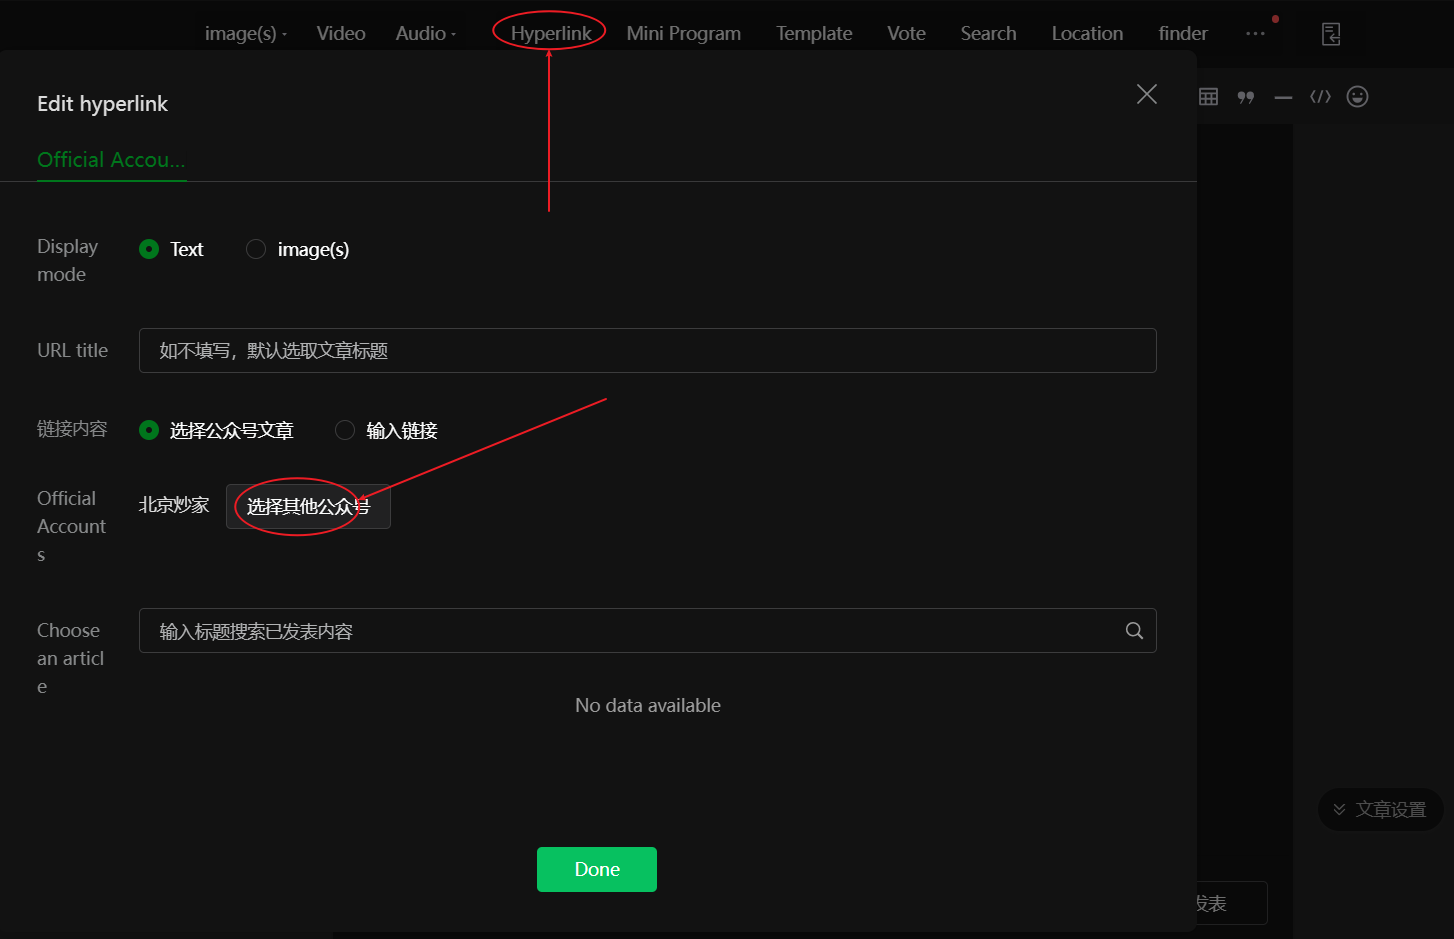

---

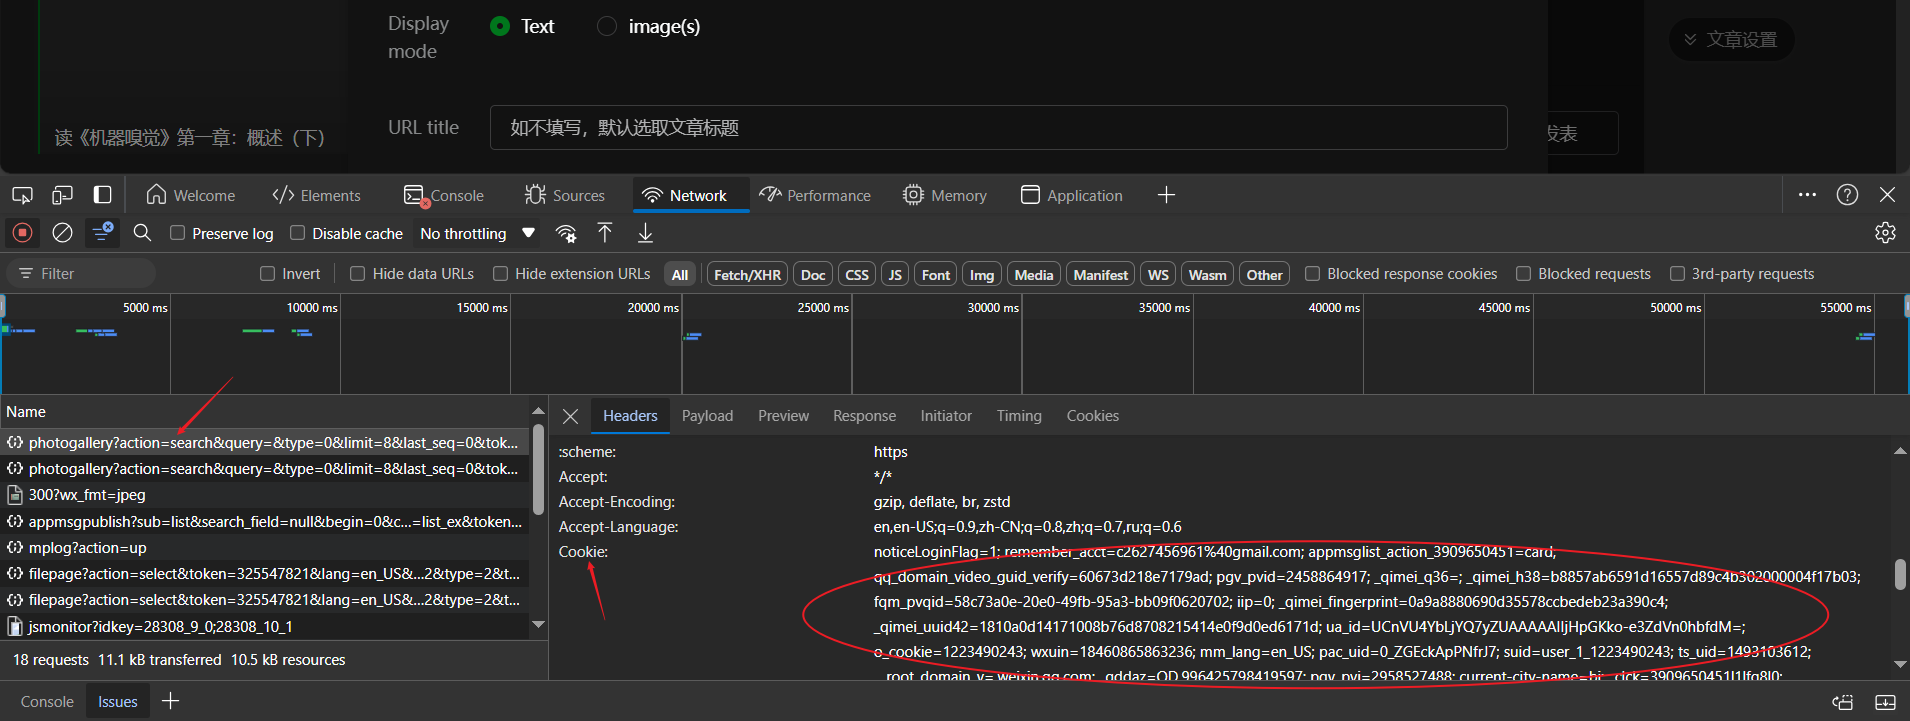

---

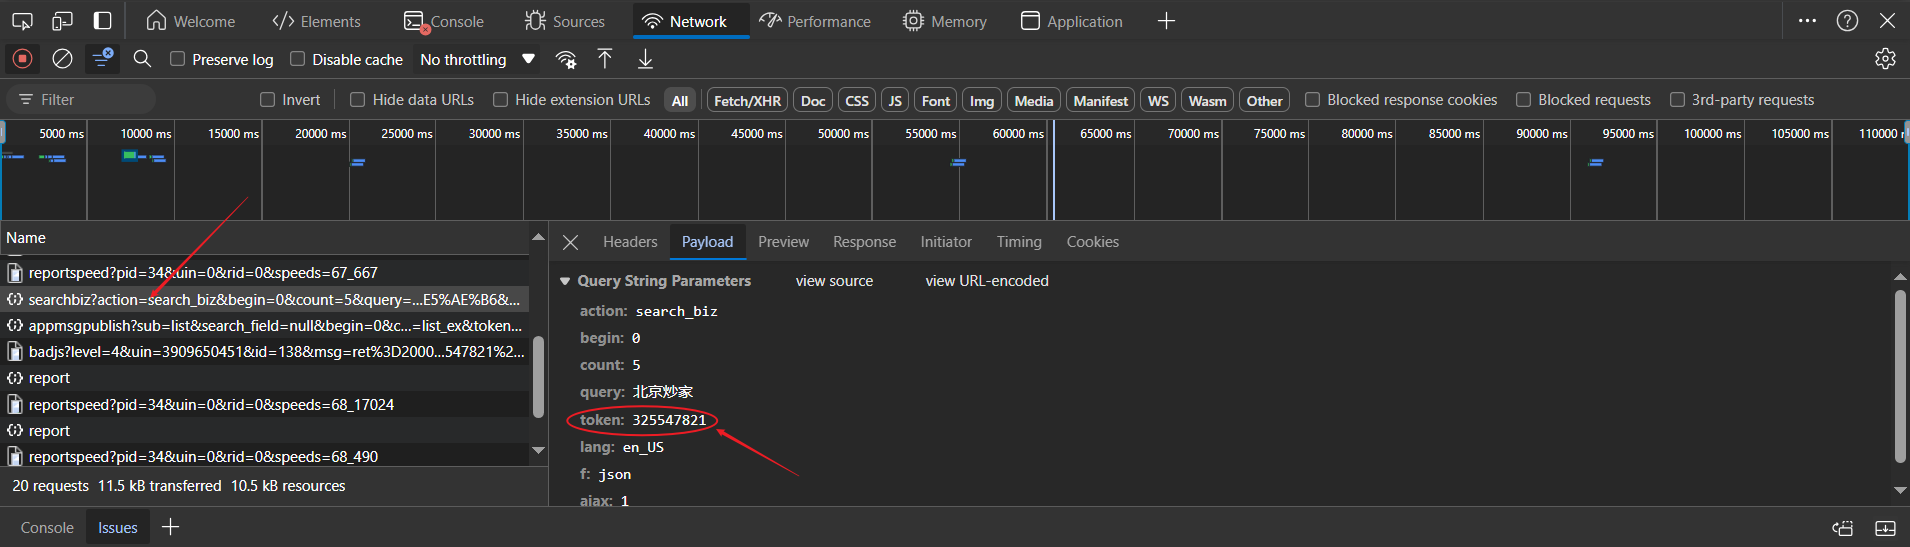

---

- `Page_Series`: Create page series.
- Attention:
  - Until 2024.10.20, there are 263 * 5 articles in 北京炒家.
  - Only 5 articles can be crawled each time.

### From CSDN
[2024最新爬取公众号文章教程1（随时可能河蟹）](https://blog.csdn.net/kuailebuzhidao/article/details/136490529)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import traceback
import requests
from pprint import pprint
from datetime import datetime
from time import sleep
import json
import random

Link_Path = "D:/AI_data_analysis/BeijingChaoJia-Data/All_Articles_Link/"

def Timestamp2Date(Timestamp):
    # Given timestamp
    # timestamp = 1729235272

    # Convert the timestamp to a datetime object
    dt_object = datetime.fromtimestamp(Timestamp)

    # Format the datetime object as a string (you can customize the format)
    formatted_date = dt_object.strftime('%Y-%m-%d %H:%M:%S')

    return formatted_date

def Find_Min_Max_Date(Date_List):
    # Convert strings to datetime objects
    date_objects = [datetime.strptime(date, "%Y-%m-%d %H:%M:%S") for date in Date_List]

    # Find the minimum and maximum date
    min_date = min(date_objects).strftime("%Y%m%d")
    max_date = max(date_objects).strftime("%Y%m%d")

    return min_date, max_date

def Page_Series(Article_Num, Begin_Num=0, Type="Descending"):
    """
    [Begin_Article_num, Count]
    Type: "Ascending" or "Descending"
    """
    Num = Article_Num - 1
    Series = []
    if Type == "Ascending":
        for i in range(Begin_Num, Num + 1, 5):
            if i + 4 > Num:
                Series.append([i, Num - i + 1])
            else: Series.append([i, 5])
    elif Type == "Descending":
        for i in range(Num + 1 - Begin_Num - 5, -5, -5):
            if i > 0:
                Series.append([i, 5])
            else: Series.append([0, i + 5])
    else: 
        print("Invalid input. Type is 'Ascending' or 'Descending'") 
        return
    return Series

def Json_Dict(Json_Path):
    """
    Json_Path: Path of a json file
    """
    with open(Json_Path, 'r', encoding='utf-8') as file:
        data_dict = json.load(file)  # Read and convert JSON to a dictionary
    return data_dict

def Dict_To_Json(Dict, Json_Path):
    """
    Dict: any dict format variable in python

    Json_Path: Path of a json file
    """
    with open(Json_Path, 'w', encoding='utf-8') as file:
        json.dump(Dict, file, ensure_ascii=False, indent=4)  # Write as formatted JSON

"""  
日期：2024年2月22日  
公众号ID：java-tech  
公众号：Java实用技术手册  
声明：本文仅供技术研究，请勿用于非法采集，后果自负。
"""

msg_json = None
Article_Num = None

__session = requests.Session()
__headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
}
__params = {
    "lang": "zh_CN",
    "f": "json",
}


def get_fakeid(nickname, begin=0, count=5):
    search_url = "https://mp.weixin.qq.com/cgi-bin/searchbiz"

    # 增加/更改请求参数
    params = {
        "action": "search_biz",
        "query": nickname,
        "begin": begin,
        "count": count,
        "ajax": "1",
    }
    __params.update(params)

    try:
        search_gzh_rsp = __session.get(search_url, headers=__headers, params=__params)
        rsp_list = search_gzh_rsp.json()["list"]
        # print(rsp_list)
        if rsp_list:
            return rsp_list[0].get("fakeid")
        return None
    except Exception as e:
        raise Exception(f"获取公众号{nickname}的fakeid失败，e={traceback.format_exc()}")


def get_articles(nickname, fakeid, begin=0, count=5, Get_Num=False):
    art_url = "https://mp.weixin.qq.com/cgi-bin/appmsg"
    art_params = {
        "query": "",
        "begin": begin,
        "count": count,
        "type": 9,
        "action": "list_ex",
        "fakeid": fakeid,
    }
    __params.update(art_params)

    global msg_json, Article_Num
    try:
        rsp_data = __session.get(art_url, headers=__headers, params=__params)
        if rsp_data:
            msg_json = rsp_data.json()
            # pprint(msg_json)
            Link_Dict = {}
            if Get_Num: # If we only get the article number
                if "app_msg_cnt" in msg_json.keys():
                    Article_Num = msg_json.get("app_msg_cnt")
                    return
            if "app_msg_list" in msg_json.keys():
                Time_List = []
                for item in msg_json.get("app_msg_list"):
                    Time = Timestamp2Date(item.get("create_time"))
                    Time_List.append(Time)
                    Link_Dict[Time] = [item.get("title"), item.get("link")]
                # result = [
                #     [item.get("title"), Timestamp2Date(item.get("create_time")), item.get("link")]
                #     for item in msg_json.get("app_msg_list")
                # ]
                # return msg_json.get('app_msg_list')
                Begin_date, End_date = Find_Min_Max_Date(Time_List)
                Json_Name = f"{Begin_date}-{End_date}.json"
                Dict_To_Json(Link_Dict, Link_Path + Json_Name)
                return Link_Dict
        return []
    except Exception as e:
        raise Exception(f"获取公众号{nickname}的文章失败，e={traceback.format_exc()}")

def main():
    # 登录微信公众号平台，获取微信文章的cookie/token
    cookie = "" # 你的cookie
    nickname = "北京炒家"

    __headers["Cookie"] = cookie
    __params["token"] = "" # 你的token

    global msg_json, Article_Num
    fakeid = get_fakeid(nickname)
    get_articles(nickname, fakeid, Get_Num=True)
    if not Article_Num: Article_Num = 1309
    print("Article Num:", Article_Num)
    print("fakeid:", fakeid)
    print("*" * 60)
    sleep(5)

    Begin_Num = 1311 # Reverse begin numner
    Page_List = Page_Series(Article_Num, Begin_Num=Begin_Num, Type="Descending")
    API_Banned = False
    print(f"Computer: from {Page_List[-1][0]} to {Page_List[0][1] if len(Page_List) == 1 else Page_List[0][0]}. Reverse: from {Begin_Num} to the end.")
    for Page in Page_List:
        # Generate a random integer time between 10 and 20 (inclusive)
        random_time = random.randint(10, 20)
        # Reverse_Begin = (Article_Num - 1 - Page[0] - 4) if Page[1] == 5 else (Article_Num - 1 - Page[0] - 4 + (5 - Page[1]))
        Reverse_Begin = Article_Num - Page[0] - Page[1]
        print(f"Begin Article: {Page[0]}, Count: {Page[1]} (Reverse: Begin {Reverse_Begin})")
        article_data = get_articles(nickname, fakeid, Page[0], Page[1])
        if not article_data: 
            print(f"API is banned, try it later. Start at {Reverse_Begin} next time.")
            API_Banned = True
            break
        pprint(article_data)
        print(f"Sleeping {random_time}s ...")
        sleep(random_time)
    if not API_Banned:
        Last_Content_Len = len(article_data)
        Next_Start = Reverse_Begin + Last_Content_Len
        print(f"All the article is obtained. Start at {Next_Start}")

if __name__ == "__main__":
    main()

Article Num: 1315
fakeid: MzU4Mzc3Njc1Nw==
************************************************************
Computer: from 0 to 4. Reverse: from 1311 to the end.
Begin Article: 0, Count: 4 (Reverse: Begin 1311)
{'2024-10-28 15:02:23': ['北哥是真矫情了！',
                         'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492572&idx=1&sn=bca01b50334ecaf52adc52f23ec30028&chksm=fda14346cad6ca50c7f5407741ad8490223999b49c0bfa5fb62de26e5cf0d80060a285377735#rd'],
 '2024-10-29 15:08:31': ['北哥非常听劝！退潮猛干了',
                         'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492578&idx=1&sn=982ec1b94f94201b80eac336ffab25c1&chksm=fda14378cad6ca6e46e15325e51fac99c8f7ed3537ff2382ff08cd87407105fad2719ceb8230#rd'],
 '2024-10-30 15:13:16': ['听劝吃大肉，感谢我的家人们！',
                         'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492587&idx=1&sn=5a8e51fc65a6d4b41f3ce748282d8ba4&chksm=fda14371cad6ca67a0f363ae3e549cafd06134c9d8302dc80d9d9ba931295af827cfdd174b1a#rd'],
 '2024-10

In [2]:
msg_json

{'app_msg_cnt': 1307,
 'app_msg_list': [{'aid': '2247489564_1',
   'album_id': '0',
   'appmsg_album_infos': [],
   'appmsgid': 2247489564,
   'checking': 0,
   'copyright_type': 0,
   'cover': 'https://mmbiz.qlogo.cn/mmbiz_jpg/IUQ03OWv6YnVzqX2IXV2U8vEkOl2Opicbh6AT3Pz6agSvibYOBx6dSroYoNhWqsHEUN4b9h0ticnORTQK4BOmWNxA/0?wx_fmt=jpeg',
   'create_time': 1678259037,
   'digest': '',
   'has_red_packet_cover': 0,
   'is_pay_subscribe': 0,
   'item_show_type': 0,
   'itemidx': 1,
   'link': 'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247489564&idx=1&sn=8240d77e66398526fd6ad13515a9f8d4&chksm=fda2b886cad53190f2d98f467efe730f625293b0238f58d67b655112ee595b0dfcba605004a7#rd',
   'media_duration': '0:00',
   'mediaapi_publish_status': 0,
   'pay_album_info': {'appmsg_album_infos': []},
   'tagid': [],
   'title': '不错！',
   'update_time': 1678259037},
  {'aid': '2247489558_1',
   'album_id': '0',
   'appmsg_album_infos': [],
   'appmsgid': 2247489558,
   'checking': 0,
   'copyright_type'

In [ ]:
# Example for msg_json

{'app_msg_cnt': 1306,
 'app_msg_list': [{'aid': '2247492534_1',
   'album_id': '0',
   'appmsg_album_infos': [],
   'appmsgid': 2247492534,
   'checking': 0,
   'copyright_type': 0,
   'cover': 'https://mmbiz.qlogo.cn/mmbiz_jpg/IUQ03OWv6YmCibrvmQAGWEm5LjAG8JFPVKw2bODHoKUy6bDnlcae7D0puibFS5eBZefj9KkicFiaFQyTPTCXXVOUrg/0?wx_fmt=jpeg',
   'create_time': 1729235272,
   'digest': '',
   'has_red_packet_cover': 0,
   'is_pay_subscribe': 0,
   'item_show_type': 0,
   'itemidx': 1,
   'link': 'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492534&idx=1&sn=a2cdf0a35f7673da355a254e586fd71e&chksm=fda1432ccad6ca3ab5a3e416d59cd84b6ca470562975944f07ea4c61f44ba1eecd31e443010a#rd',
   'media_duration': '0:00',
   'mediaapi_publish_status': 0,
   'pay_album_info': {'appmsg_album_infos': []},
   'tagid': [],
   'title': '大涨日我爆亏！',
   'update_time': 1729235271},
  {'aid': '2247492528_1',
   'album_id': '0',
   'appmsg_album_infos': [],
   'appmsgid': 2247492528,
   'checking': 0,
   'copyright_type': 0,
   'cover': 'https://mmbiz.qlogo.cn/mmbiz_jpg/IUQ03OWv6YlyXp59NQrbgaVcU1NDoGSLwnn447UEGnZkFDDs9BDRWyu25Y6XibohAgRvaCTEIyaibNY491hD50Sg/0?wx_fmt=jpeg',
   'create_time': 1729148873,
   'digest': '',
   'has_red_packet_cover': 0,
   'is_pay_subscribe': 0,
   'item_show_type': 0,
   'itemidx': 1,
   'link': 'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492528&idx=1&sn=d56c4136ede344c73666830493d06021&chksm=fda1432acad6ca3c4811c78e1c6cc8ad7ed2555c875b2039e65556163ded1a4190266d9baf29#rd',
   'media_duration': '0:00',
   'mediaapi_publish_status': 0,
   'pay_album_info': {'appmsg_album_infos': []},
   'tagid': [],
   'title': '小仓亏大钱最惨的一次',
   'update_time': 1729148873},
  {'aid': '2247492522_1',
   'album_id': '0',
   'appmsg_album_infos': [],
   'appmsgid': 2247492522,
   'checking': 0,
   'copyright_type': 0,
   'cover': 'https://mmbiz.qlogo.cn/mmbiz_jpg/IUQ03OWv6YlG1aztg0JhogZZbyic1QP3z2KgUUNLGbl46oIbyHpnibPO3e9ibCBsROgicHKMviaibXtBTPXE4SjQvI5A/0?wx_fmt=jpeg',
   'create_time': 1729062514,
   'digest': '',
   'has_red_packet_cover': 0,
   'is_pay_subscribe': 0,
   'item_show_type': 0,
   'itemidx': 1,
   'link': 'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492522&idx=1&sn=db4767efd2226c0cc5e88b4fa380aece&chksm=fda14330cad6ca26654d73c1022ce582aa11b1427411c059d17952699a48479103fe0e8ec9e0#rd',
   'media_duration': '0:00',
   'mediaapi_publish_status': 0,
   'pay_album_info': {'appmsg_album_infos': []},
   'tagid': [],
   'title': '盘中山顶挺凉快',
   'update_time': 1729062514},
  {'aid': '2247492515_1',
   'album_id': '0',
   'appmsg_album_infos': [],
   'appmsgid': 2247492515,
   'checking': 0,
   'copyright_type': 0,
   'cover': 'https://mmbiz.qlogo.cn/mmbiz_jpg/IUQ03OWv6YmD2fxOrt4tMTwnveAXiagMZEcujFL3nKXXb58w1FHsjwcWiajcHgJibBBwS5rLdoXlr0JvTTKjW6LjQ/0?wx_fmt=jpeg',
   'create_time': 1728976215,
   'digest': '',
   'has_red_packet_cover': 0,
   'is_pay_subscribe': 0,
   'item_show_type': 0,
   'itemidx': 1,
   'link': 'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492515&idx=1&sn=5390a94da9e64b050b5e90e4d16d2dd5&chksm=fda14339cad6ca2f2a9f1b5a374975c3ea4ad2c98f43948de154fe2db0241f35a4d2785a2558#rd',
   'media_duration': '0:00',
   'mediaapi_publish_status': 0,
   'pay_album_info': {'appmsg_album_infos': []},
   'tagid': [],
   'title': '紧张的要死！',
   'update_time': 1728976215},
  {'aid': '2247492509_1',
   'album_id': '0',
   'appmsg_album_infos': [],
   'appmsgid': 2247492509,
   'checking': 0,
   'copyright_type': 0,
   'cover': 'https://mmbiz.qlogo.cn/mmbiz_jpg/IUQ03OWv6YkZRRCeicxPbESYsxmL6KajOtq3OaWR5pgdneP3jmpadgiaicP67sRb0L5YJpbQUL7VVI8CDRHeHrReQ/0?wx_fmt=jpeg',
   'create_time': 1728889538,
   'digest': '',
   'has_red_packet_cover': 0,
   'is_pay_subscribe': 0,
   'item_show_type': 0,
   'itemidx': 1,
   'link': 'http://mp.weixin.qq.com/s?__biz=MzU4Mzc3Njc1Nw==&mid=2247492509&idx=1&sn=5faec5a306b73e5aaf48f01561a4037c&chksm=fda14307cad6ca115b8d97d28008847d3601221f8c045658a62009d81bbfaf5885f3a88b0180#rd',
   'media_duration': '0:00',
   'mediaapi_publish_status': 0,
   'pay_album_info': {'appmsg_album_infos': []},
   'tagid': [],
   'title': '严重踏空！',
   'update_time': 1728889537}],
 'base_resp': {'err_msg': 'ok', 'ret': 0}}